<a href="https://colab.research.google.com/github/agdylan/research_code/blob/main/Register_MNIST_5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --no-dependencies icon_registration==1.1.2

  Attempting uninstall: icon_registration
    Found existing installation: icon-registration 1.1.1
    Uninstalling icon-registration-1.1.1:
      Successfully uninstalled icon-registration-1.1.1


In [ ]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt

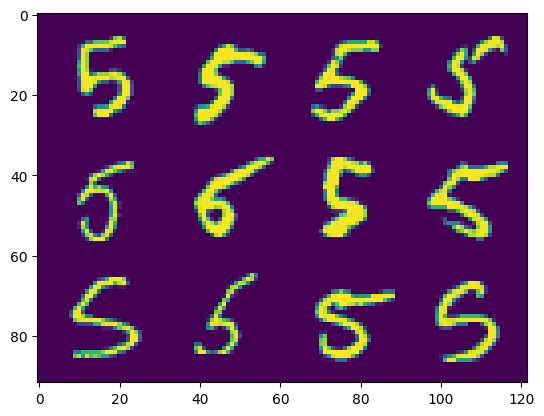

In [ ]:
ds, _ = icon_registration.data.get_dataset_mnist(split="train", number=5)

sample_batch = next(iter(ds))[0]
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

In [ ]:
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
     inner_net = icon.TwoStepRegistration(
         icon.DownsampleRegistration(inner_net, dimension=2),
         icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
     )

net = icon.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=.5) # Here we can change the regularizers that we are usuing
# Ex: icon.bendingenergy, icon.diffusion
# Gradicon is expected to have greater variation between training so this is what we are testing for
# Look in the paper for the best values for the inputs
net.assign_identity_map(sample_batch.shape)

100%|██████████| 5/5 [00:56<00:00, 11.26s/it]


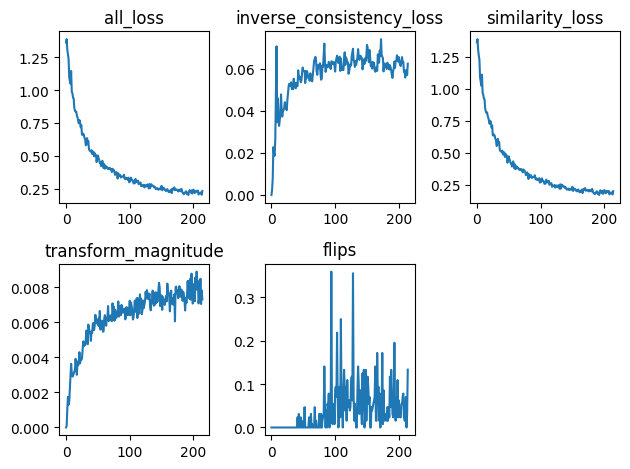

In [ ]:
net.train()
net.to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)
curves = icon.train_datasets(net, optim, ds, ds, epochs=5)
for i, name in enumerate(curves[0]._fields):
  plt.subplot(2, 3, i + 1)
  plt.plot([getattr(c, name) for c in curves])
  plt.title(name)
plt.tight_layout()

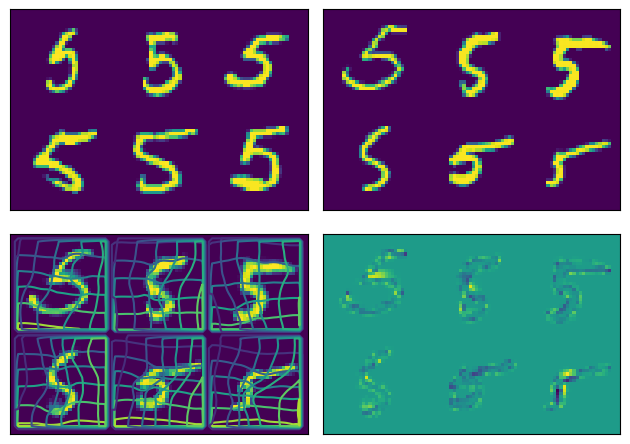

In [ ]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:6], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])
image_A = next(iter(ds))[0].to(device)
image_B = next(iter(ds))[0].to(device)
net(image_A, image_B) # call network on the images to get outputs
plt.subplot(2, 2, 1)
show(image_A)
plt.subplot(2, 2, 2)
show(image_B)
plt.subplot(2, 2, 3)
show(net.warped_image_A)
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[0].cpu().detach()) # Draws vertical grid lines
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[1].cpu().detach()) # Draws horiziontal grid lines
plt.subplot(2, 2, 4)
show(net.warped_image_A - image_B)
plt.tight_layout()

# Running to see if the lines in the bottom left are goiing to be different each time
# Most interesting thing would be create a heat map for each regularization technique
# 30 trials for each of the regularizers, GradIcon, Diffusion, Bending Energy

# Generating the heat map
# Curious about the statistical properties of the vectors and the covariance matrix
# Expectation is the vectors are similar to each other for diffusion and different for GradIcon
# Final product targeting is a pdf writeup describing the question and looking into the literature about what people have said before about network training, comparing Gradicon to other techniques